In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import hashlib
import matplotlib
matplotlib.rc('font', size=15)

# Hexagon grid conversions

Define a tessellating hexagonal grid as a set of hexagons $\mathcal{H}$ which covers the cartesian plane $\mathbb{R}^2$. Each hexagon $h_{i,j} \in \mathcal{H}$ has an integer address $\{i, j\} \in \mathbb{Z}^2$. The hexagons do not overlap so the intersection of any two distinct $h$ is empty, and the cartesian space is covered such that any coordinate $\{x, y\} \in \mathbb{R}^2$ belongs to some $h_{i,j}$.

We can therefore define the grid with a function $f : \mathbb{R}^2 \rightarrow \mathbb{Z}^2$ that maps coordinates in cartesian space to the corresponding hexagon address. This function is useful in the context of a computer interaction where a user selects a pixel location on a rendering of the hexagonal grid, and we which to find the corresponding grid coordinates.

Without loss of generality, assume that the hex grid is "flat topped" as defined in [1], and the hexagonal grid coordinates are "Axial Coordinates" as defined in [1].

[1]: <https://www.redblobgames.com/grids/hexagons/>

## Hexagon geometry

We need to determine the shape of each hexagon. Clearly for the obvious tessellation we need each hexagon to be the same size, however they do not need to be regular, as any simple scaling of the coordinates could easily be inverted to get regular hexagons if that was so desired. A regular hexagon with side 1 has a height of $\sqrt{3}$ so it is in fact more convenient to choose a non-regular geometry.

Define the hexagon shape so that the distances between hexagons are small whole numbers: a small section of the tessellation is shown below - the vertical space between adjacent hexagons in the same "column" (labelled $h$) is 2, and the vertical space relative to the hexagon in the next column is 1. The horizontal space ($w$) is 1.

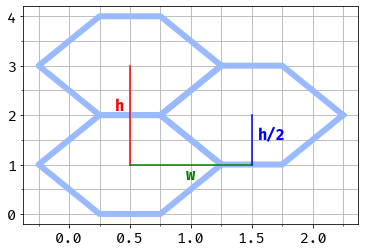

In [6]:
def hex_points():
    h=2
    w=1
    p=0.5
    return np.array([
        [w/4+p,0],
        [w/4, h/2],
        [-w/4, h/2],
        [-w/4-p, 0],
        [-w/4, -h/2],
        [w/4, -h/2],
        [w/4+p,0]
    ])

points = (hex_points() + [0.5, 1])
hex_color='#99baff'
plt.plot(*points.transpose(), lw=6, color=hex_color)
plt.plot(*(points + [1, 1]).transpose(), lw=6, color=hex_color)
plt.plot(*(points + [0, 2]).transpose(), lw=6, color=hex_color)
plt.grid(which='both')
ax = plt.gca()
ax.set_xticks(np.arange(-0.25, 2.26, 0.25), minor=True)
ax.set_yticks(np.arange(-0, 4.1, 0.5), minor=True)
plt.plot([0.5, 0.5], [1, 3], color='red')
plt.annotate('h', [0.5, 2.5], [0.45, 2.1], horizontalalignment='right', color='red', weight='bold')

plt.plot([0.5, 1.5], [1, 1], color='green')
plt.annotate('w', [0.7, 0.7], [1, 0.7], horizontalalignment='center', color='green', weight='bold')

plt.plot([1.5, 1.5], [1, 2], color='blue')
plt.annotate(r'h/2', [1.5, 1.5], [1.55,1.5], horizontalalignment='left', color='blue', weight='bold')

None

## Colouring the hexagons

As noted at the start, each hexagon has an address $\{i, j\}$. In order to better understand our representations of the grid, we will pick a pseudo-random colour for each hexagon using its address and the SHA-256 hash function.


In [154]:
import hashlib

def color_for_hex(i, j):
    """Calculates a size 3 array of floats that can be used as a color
    
    The input values are put into a byte string and passed to the sha256
    hash function. 
    """
    buffer = np.array([i, j], dtype=np.int32).tobytes()
    hash_data = hashlib.sha256(buffer).digest()
    return np.frombuffer(hash_data, dtype=np.uint8)[:3].astype(float)/255

print(color_for_hex(1, 1))
# The function is deterministic, and only considers integer values, so this
# will print the same output
print(color_for_hex(1.1, 1))
# Another example
print(color_for_hex(23, -123))

[0.39215686 0.92941176 0.5254902 ]
[0.39215686 0.92941176 0.5254902 ]
[0.08235294 0.17254902 0.38431373]


## Addressing the rectangular grid

The addresses for the hexagons have to components $i$ and $j$. The first addresses the column (so increases along the $x$ direction). As we move up a column, the $j$ component increases, but has an offset which ensures that for any given tile, a move in one of the six available directions always has the same change in $\{i, j\}$ (for example, moving to the tile up and to the right of any $\{i, j\}$, always moves to address $\{i+1, j+1\}$).

Given the $\{i, j\}$ coordinates of a hexagon, we can find the origin of the hexagon in the cartesian plane. We have established that the horizontal spacing between hexagons is 1, so the $x$ coordinate is simply $i$. 

The vertical spacing is 2, so we expect a factor of $2j$ in the $y$ value. To acheive the correct offset, we need to subtract $i$ to move the hexagon down by one for each column. 

In [155]:
def axial_to_world(i, j):
    x = np.float(i)
    y = np.float(2*j - i)
    return x,y

Plotting our hexagon geometry on this grid, and using the random colours to fill them in:

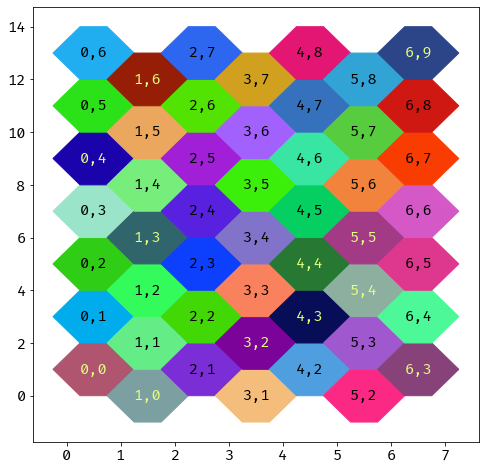

In [156]:
from matplotlib import colors
def plot_hex(ax, i, j):
    x, y = axial_to_world(i, j)
    color = color_for_hex(i, j)
    points = hex_points()+np.array([x+0.5,y+1])
    ax.fill(*points.transpose(), color=color)
    # Naive algorithm to pick a contrasty text color
    text_color = colors.rgb_to_hsv(color)
    text_color[1] = 0.5
    text_color[2] = np.round(1.2-text_color[2])
    text_color[0] = 0.6 if text_color[2] < 0.5 else 0.2
        
    text_color = colors.hsv_to_rgb(text_color)
    ax.annotate(f'{i},{j}', (x+0.5, y+1), horizontalalignment='center', verticalalignment='center', color=text_color)
    
    
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()

for i in range(0, 7):
    for j in range(0, 7):
        j = j + i//2
        plot_hex(ax, i, j)

In [157]:
def world_to_axial(x, y):
    i = np.int(np.floor(x))
    j = np.int(np.floor((y+i)/2))
    
    origin_x, origin_y = axial_to_world(i, j)
    local_x = x - origin_x
    local_y = (y - origin_y)/2
    
    if local_x + local_y < 0.25:
        return i-1, j-1
    elif local_x + (1-local_y) < 0.25:
        return i-1, j
    elif (1-local_x) + (1-local_y) < 0.25:
        return i+1, j+1
    elif (1-local_x) + local_y < 0.25:
        return i+1, j
    else:
        return i, j
        


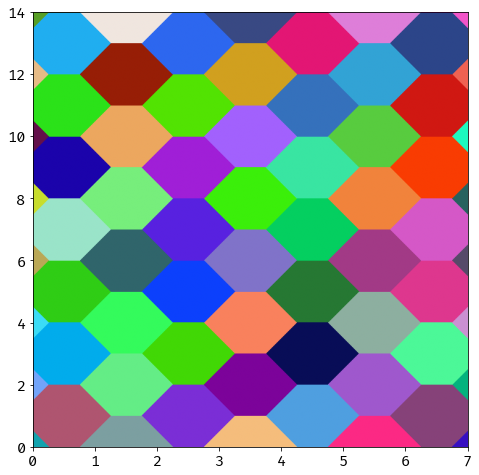

In [158]:
x_values = np.linspace(0,7,600)
y_values = np.linspace(0,14,600)
img_rgba = np.zeros((len(y_values), len(x_values), 3), dtype=np.float)
for j, y in enumerate(y_values):
    for i, x in enumerate(x_values):
        img_rgba[j, i, :] = color_for_hex(*world_to_axial(x,y))
        
plt.figure(figsize=(8,8))
plt.imshow(img_rgba, origin='lower', extent=(x_values[0], x_values[-1], y_values[0], y_values[-1]), aspect=0.5)
None